In [2]:
!gdown --id 1klGCOc2TbX_FJeJE9YdBspxSb35ca--f
!gdown --id 1IATbUxdkkj-S29CSKhhs0cXVorBspvlp

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1klGCOc2TbX_FJeJE9YdBspxSb35ca--f
To: /content/train.csv
100% 53.8M/53.8M [00:00<00:00, 110MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IATbUxdkkj-S29CSKhhs0cXVorBspvlp
To: /content/test.csv
100% 35.1M/35.1M [00:00<00:00, 72.3MB/s]


# Импорт библиотек, настройка среды

In [3]:
# Работа с данными
import numpy as np
import pandas as pd
import random

# Визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# Предобработка данных
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Разделение данных и метрики
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Модели машинного обучения
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Работа с классами и балансировка
from sklearn.utils.class_weight import compute_class_weight

# Создание и обучение NN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Подбор гиперпараметров
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.5 MB/s eta 0:00:00


In [4]:
# Фиксируем seed для Python
random.seed(42)

# Фиксируем seed для NumPy
np.random.seed(42)

# Фиксируем seed для TensorFlow
tf.random.set_seed(42)

# Знакомство с данными

In [5]:
# В рамках текущего проекта представлен тренировочный и тестовые датасеты. Необходимо загрузить их и вывести общую информацию
cardio_train = pd.read_csv('/content/train.csv', sep=',')
cardio_test = pd.read_csv('/content/test.csv', sep=',')

# Создаём копии датасетов для дальнейшей работы
cardio_train_copy = cardio_train.copy()
cardio_test_copy = cardio_test.copy()

display(cardio_train_copy.info(), cardio_test_copy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

None

None

Тестовый и тренировочный датасеты имеют одинаковые признаки за исключением отсутствующего в тестовом датасете целевого столбца class. Суммарное количество записей в датасетах - 1000000 (600000 в тренировочном и 400000 в тестовом). Всего имеется 15 признаков:

- Age (возраст);
- Sex (пол);
- Resting_blood_pressure (артериальное давление в состоянии покоя);
- Serum_cholestoral (уровень холестерина в крови mg/dl);
- Fasting_blood_sugar (анализ глюкозы в крови натощак (> 120 mg/dl));
- Maximum_heart_rate_achieved (максимальная частота сердечных сокращений);
- Exercise_induced_angina (стенокардия при нагрузке),
- Oldpeak (депрессия ST-сегмента);
- Slope (наклон пикового сегмента ST при физической нагрузке);
- Number_of_major_vessels (количество крупных сосудов (0-3), окрашенных с помощью флюороскопии);
- Resting_electrocardiographic_results (результаты электрокардиографических исследований в покое 0, 1, 2);
- Thal (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
- Chest_bin (боль в груди от 1 до 4).

Так как на этапе подготовки датасетов необходимо провети одинаковую обработку как тренировочного, так и тестового датасетов, имеет смысл их объединить, подготовить, после чего снова разделить.

In [6]:
# Для начала посмотрим количестов дубликатов в датасетах
display(f'Количество дубликатов в тренировочном датасете: {int(cardio_train_copy.duplicated().sum())}')
display(f'Количество дубликатов в тестовом датасете: {int(cardio_test_copy.duplicated().sum())}')

'Количество дубликатов в тренировочном датасете: 0'

'Количество дубликатов в тестовом датасете: 0'

In [7]:
# Теперь можно избавиться от ненужных признаков. В данном датсете к таким признакам можно отнести только ID
cardio_train_copy = cardio_train_copy.drop(columns=['ID'], axis=0)
cardio_test_copy = cardio_test_copy.drop(columns=['ID'], axis=0)

In [53]:
#display(cardio_train_copy.head(5))
#display(cardio_test_copy.head(5))

In [54]:
# Объединим датасеты
cardio_full_copy = pd.concat([cardio_train_copy, cardio_test_copy], axis=0)
#display(cardio_full_copy)

После объединения, как и планировалось, получилось 400000 null-записей по целевому признаку class. После подготовки данных будем использовать эту особенность для разделения на тренировочный и тестовый датасеты.

Беглай анализ позволил выделить ряд числовых и категориальных признаков.

Числовые признаки:
- Возраст;
- Артериальное давление в состоянии покоя;
- Уровень холестерина в крови;
- Максимальная частота сердечных сокращений;
- Депрессия ST-сегмента;

Категориальные признаки:
- Пол;
- Анализ глюкозы в крови натощак (> 120 mg/dl);
- Стенокардия при нагрузке;
- Наклон пикового сегмента ST при физической нагрузке;
- Количество крупных сосудов (0-3), окрашенных с помощью флюороскопии;
- Результаты электрокардиографических исследований в покое 0, 1, 2;
- Thal (3 = норма; 6 = фиксированный дефект; 7 = обратимый дефект);
- Боль в груди от 1 до 4.

In [10]:
# Зададим списки количественных и качественных признаков для упрощения дальнейшей работы с ними
quant_cols = ['age', 'chest', 'resting_blood_pressure', 'serum_cholestoral', 'maximum_heart_rate_achieved', 'oldpeak']
cat_cols = list(cardio_full_copy.columns.difference(quant_cols))

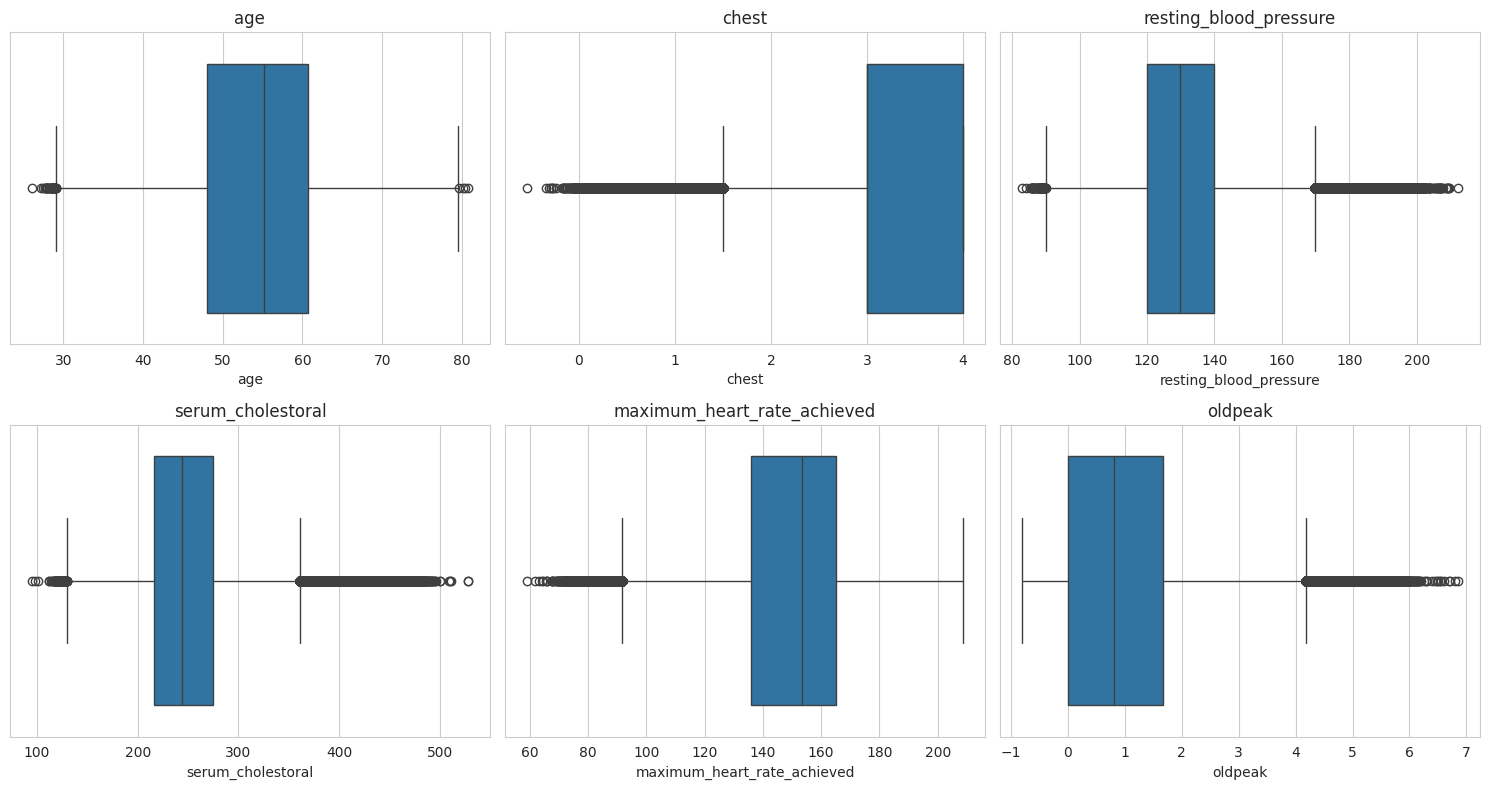

In [11]:
# Для анализа выбросов в числовых признаках выведем boxplot-графики
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(quant_cols):
    sns.boxplot(data=cardio_full_copy, x=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [12]:
# Визуально выбросов не обнаружено, взглянем на статистические показатели данных признаков
display(round(cardio_full_copy[quant_cols].describe().T, 2))

,count,mean,std,min,25%,50%,75%,max
age,1000000.0,54.42,9.09,26.06,48.06,55.13,60.67,80.75
chest,1000000.0,3.17,0.95,-0.54,3.00,3.00,4.00,4.00
resting_blood_pressure,1000000.0,131.35,17.85,82.92,119.93,129.73,139.92,212.30
serum_cholestoral,1000000.0,249.59,51.71,94.96,216.47,244.25,274.35,527.76
maximum_heart_rate_achieved,1000000.0,149.62,23.07,58.96,135.75,153.27,165.19,208.74
oldpeak,1000000.0,1.05,1.14,-0.81,0.00,0.81,1.67,6.86


Приведённые статистики по числовым данным позволяют сделать несколько выводов:
- признаки age, resting_blood_pressure, serum_cholestoral, maximum_heart_rate_achieved имеют адекватные границы расперделения величин, последующая обработка данных не требуется;
- Признаки oldpeak (депрессия ST-сегмента) и сhest (боль в груди от 1 до 4) имеют значения ниже нуля, что требует дополнительной обработки

In [13]:
# Заменим отрицательные значения в признаках oldpeak и chest на медианные, выведенные после группировки по полу и статусу наличия ССЗ
cardio_full_copy['chest'] = cardio_full_copy['chest'].mask(
    cardio_full_copy['chest'] < 1,
    cardio_full_copy.groupby(['sex','class'])['chest'].transform('median')
)

cardio_full_copy['oldpeak'] = cardio_full_copy['oldpeak'].mask(
    cardio_full_copy['oldpeak'] < 0,
    cardio_full_copy.groupby(['sex', 'class'])['oldpeak'].transform('median')
)

In [14]:
# Приведём все признаки к одной шкале, для этого произведём масштабирование
scaler = MinMaxScaler()

# применяем только к количественным признакам
cardio_full_copy[quant_cols] = scaler.fit_transform(cardio_full_copy[quant_cols])

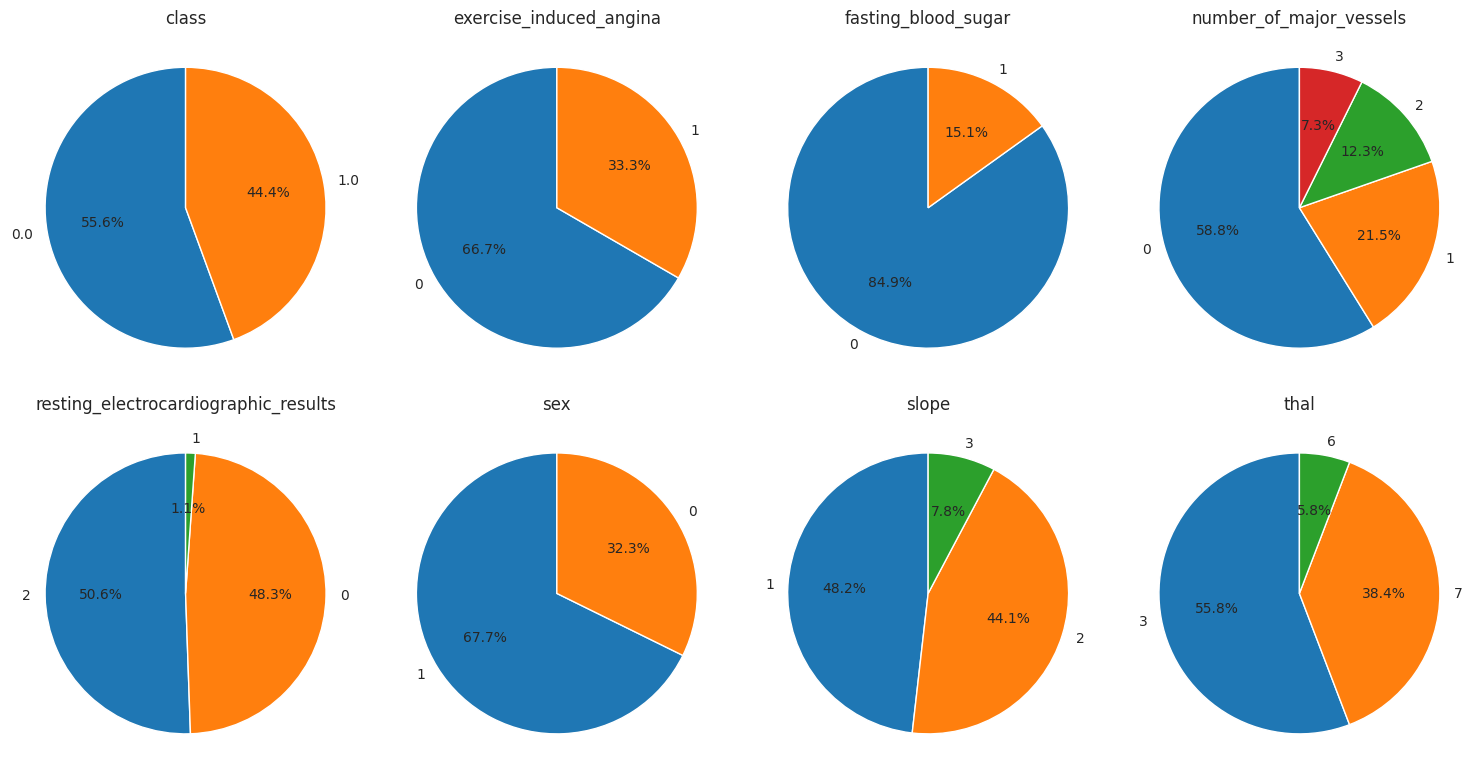

In [15]:
# Теперь построим круговые диаграммы для категориальных признаков
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    counts = cardio_full_copy[col].value_counts(normalize=True)
    labels = counts.index
    sizes = counts.values

    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(col)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Следует отметить, что распределение по целевой переменной практически равное (class). Последующая балансировка классов не требуется. Также следует обратить внимание на параметры number_of_major_vessels, resting_electrocardiographic_results, slope и thal. Они являются небинарными, потому их следует перевести в бинарный вид. Воспользуемся OneHot кодировкой

In [16]:
cols_to_convert = ['number_of_major_vessels', 'resting_electrocardiographic_results', 'slope', 'thal']

# Создаем и применяем OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
cardio_full_copy_onehot = one_hot_encoder.fit_transform(cardio_full_copy[cols_to_convert])

# Получаем имена новых столбцов
columns = one_hot_encoder.get_feature_names_out(cols_to_convert)

# Преобразуем результат в датафрейм
cardio_full_copy_onehot = pd.DataFrame(cardio_full_copy_onehot.astype(int), columns=columns, index=cardio_full_copy.index)

# Объединяем с исходными данными (если нужно)
cardio_full_copy = pd.concat([cardio_full_copy.drop(cols_to_convert, axis=1), cardio_full_copy_onehot], axis=1)

In [17]:
# Выводим итоговый датасет
display(cardio_full_copy, cardio_full_copy.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   age                                     1000000 non-null  float64
 1   sex                                     1000000 non-null  int64  
 2   chest                                   993047 non-null   float64
 3   resting_blood_pressure                  1000000 non-null  float64
 4   serum_cholestoral                       1000000 non-null  float64
 5   fasting_blood_sugar                     1000000 non-null  int64  
 6   maximum_heart_rate_achieved             1000000 non-null  float64
 7   exercise_induced_angina                 1000000 non-null  int64  
 8   oldpeak                                 998394 non-null   float64
 9   class                                   600000 non-null   float64
 10  number_of_major_vessels_1           

,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,class,number_of_major_vessels_1,number_of_major_vessels_2,number_of_major_vessels_3,resting_electrocardiographic_results_1,resting_electrocardiographic_results_2,slope_2,slope_3,thal_6,thal_7
0,0.423212,0,1.000000,0.618923,0.199055,0,0.596000,1,0.137765,1.0,0,0,0,0,0,1,0,0,0
1,0.504055,1,0.247198,0.365701,0.419403,0,0.627309,0,0.017367,0.0,0,0,0,0,1,1,0,0,0
2,0.430239,1,1.000000,0.495280,0.296541,1,0.289693,1,0.235807,1.0,0,1,0,0,1,1,0,0,1
3,0.602117,1,1.000000,0.227625,0.213234,0,0.662347,1,0.000000,1.0,1,0,0,0,0,0,0,0,1
4,0.456975,1,0.318203,0.425974,0.331621,0,0.758335,0,0.167799,0.0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0.536002,0,0.666667,0.221905,0.409319,0,0.638437,0,0.000000,NaN,0,0,0,0,0,0,0,0,0
399996,0.506876,1,1.000000,0.153812,0.439609,0,0.629547,1,0.000000,NaN,0,0,1,0,1,0,0,0,1
399997,0.538841,0,0.351298,0.183472,0.267821,0,0.622982,1,0.250786,NaN,0,0,0,0,1,1,0,0,0
399998,0.537220,1,1.000000,0.273883,0.429552,0,0.673405,0,0.000000,NaN,0,0,0,0,1,0,0,0,0


None

In [18]:
# В датасете присутствуют пропущенные значения в признаках chest и oldpeak. Заменим пропуски медианными значениями после группировки по полу
cardio_full_copy[['chest', 'oldpeak']] = cardio_full_copy[['chest', 'oldpeak']].fillna(
    cardio_full_copy.groupby(['sex'])[['chest', 'oldpeak']].transform('median')
)

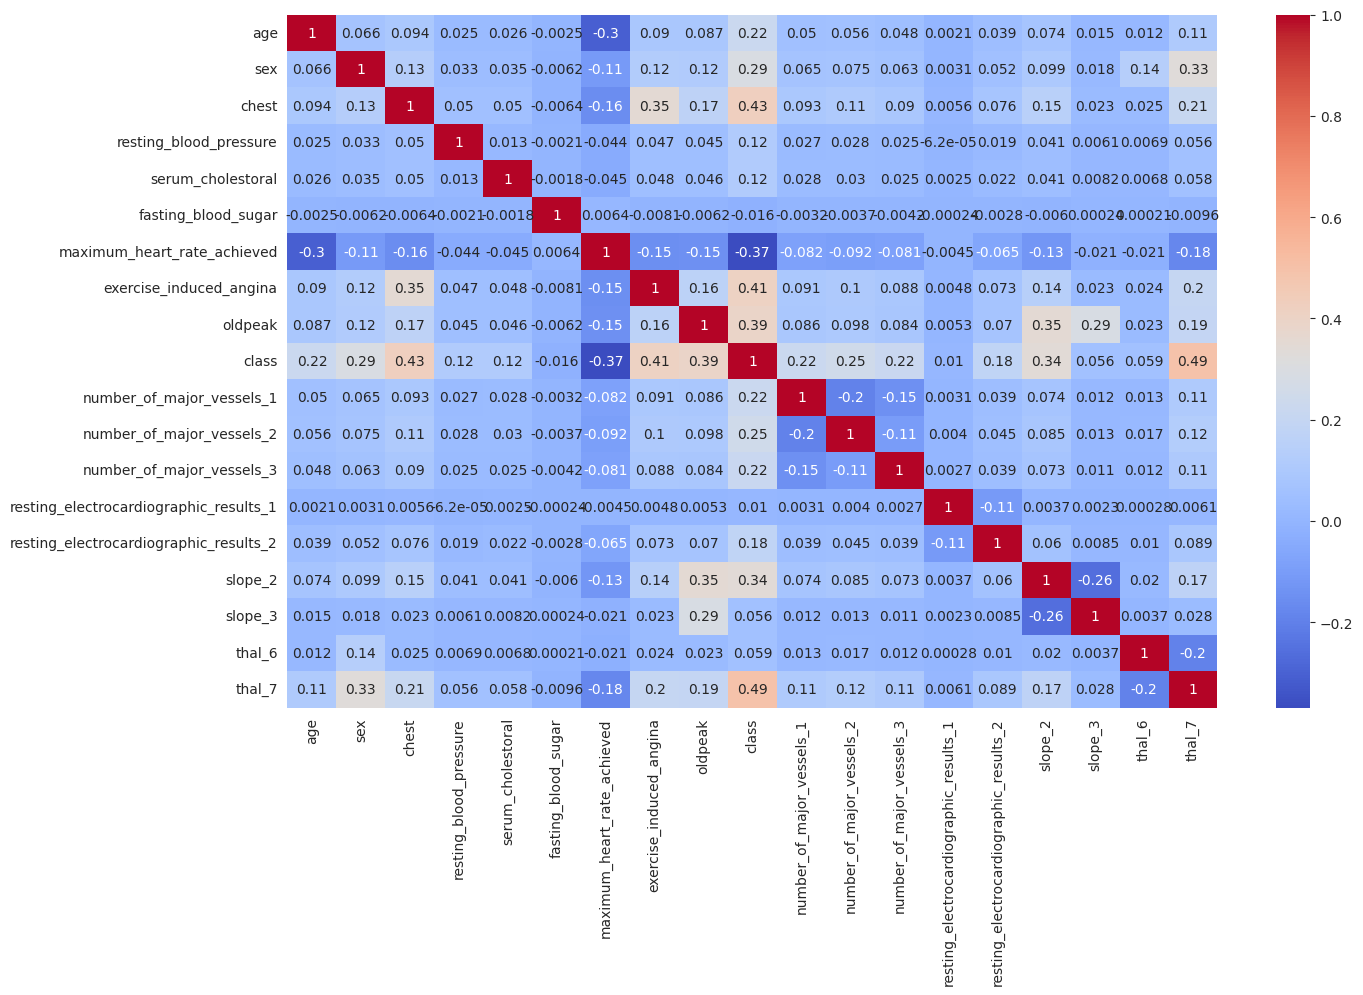

In [19]:
# Выведем матрицу корреляций признаков
cardio_full_copy_corr = cardio_full_copy.corr()

fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(cardio_full_copy_corr, annot=True, cmap='coolwarm')
plt.show()

В датасете не наблюдается признаков, обладающих высокой корреляцией с целевым признаком. Также отсутствует мультиколлинеарность.

In [20]:
display(cardio_full_copy.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   age                                     1000000 non-null  float64
 1   sex                                     1000000 non-null  int64  
 2   chest                                   1000000 non-null  float64
 3   resting_blood_pressure                  1000000 non-null  float64
 4   serum_cholestoral                       1000000 non-null  float64
 5   fasting_blood_sugar                     1000000 non-null  int64  
 6   maximum_heart_rate_achieved             1000000 non-null  float64
 7   exercise_induced_angina                 1000000 non-null  int64  
 8   oldpeak                                 1000000 non-null  float64
 9   class                                   600000 non-null   float64
 10  number_of_major_vessels_1           

None

Итоговый датасет готов, теперь его можно обратно разбить на тренировочную и тестовую выборки.

In [21]:
cardio_train_copy = cardio_full_copy[cardio_full_copy['class'].notna()]
cardio_test_copy = cardio_full_copy[cardio_full_copy['class'].isna()]

# Обучение моделей

## Разделение данных

In [22]:
#Разделим первый датасет на матрицу наблюдений (X_train_full) и вектор правильных ответов (Y_train_full)
X_train_full = cardio_train_copy.drop('class', axis=1)
Y_train_full = cardio_train_copy['class']

In [23]:
#Разделим получившиеся матрицы наблюдений и правильных ответов на тренировочные и валидационные наборы в соотношении 80/20
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, Y_train_full, test_size=0.3, random_state=42
)
#Выведем размеры получившихся наборов
print('Размер тренировочного датасета: {}'.format(X_train.shape))
print('Размер валидационного датасета: {}'.format(X_valid.shape))

Размер тренировочного датасета: (420000, 18)
Размер валидационного датасета: (180000, 18)


## Оценка качества моделей

Для оценки качеств моделей напишем метод, принимающий на входе модель, а на выходе возвращающий словарь, ключами которого будет 4 метрики (Accuracy, Precision, Recall, F1-Score).

In [24]:
def model_quality_estimation(model):
    """
    Оценивает качество нейросети с помощью основных метрик классификации.

    Параметры:
    ----------
    model : keras.Model
        Обученная нейросеть.
    X_eval : np.array
        Данные для оценки (по умолчанию X_valid).
    y_eval : np.array
        Истинные метки классов (по умолчанию y_valid).
    threshold : float
        Порог для преобразования вероятностей в бинарные метки (по умолчанию 0.5).

    Возвращаемые значения:
    ----------------------
    dict
        Словарь с оценочными показателями:
        - 'Accuracy'
        - 'Precision'
        - 'Recall'
        - 'F1-Score'
    """

    # Получаем предсказанные значения
    if model.__class__.__name__ == 'Sequential':
      y_pred = (model.predict(X_valid) >= 0.5).astype(int)

    else:
      y_pred = model.predict(X_valid)

    # Рассчитываем метрики
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    # Формируем словарь с результатами
    result = {
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    }

    return result

## Логистическая регрессия

In [25]:
# Создадим и обучим модель без настройки гиперпараметров
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [26]:
# Вывод текущих гиперпараметров
print("Гиперпараметры используемой логистической регрессии без настройки:")
for param, value in lr.get_params().items():
    print(f"{param}: {value}")

Гиперпараметры используемой логистической регрессии без настройки:
C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: deprecated
n_jobs: None
penalty: l2
random_state: 42
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False


In [27]:
lr_metrics = model_quality_estimation(lr)
display(f'Метрики логистической регрессии без настройки: {lr_metrics}')

"Метрики логистической регрессии без настройки: {'Accuracy': 0.885, 'Precision': 0.8783, 'Recall': 0.8603, 'F1-Score': 0.8692}"

## Подбор гиперпараметров

In [28]:
# Функция для оптимизации гиперпараметров модели логистической регрессии
def optuna_lr(trial: optuna.trial.Trial) -> float:
    # Подбор основных гиперпараметров
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])  # Решатель
    C = trial.suggest_float('C', 0.01, 10, log=True)

    # Создание конвейера: стандартизация + логистическая регрессия
    model = LogisticRegression(
              solver=solver,
              C=C,
              max_iter=500,
              random_state=42
        )

    # Обучение модели
    model.fit(X_train, y_train)

    # Оценка модели на валидационном наборе
    preds = model.predict(X_valid)
    score = accuracy_score(y_valid, preds)

    return score

In [29]:
# Создаем объект исследования для подбора гиперпараметров
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")

# Ищем лучшую комбинацию гиперпараметров 25 раз
study_lr.optimize(optuna_lr, n_trials=25)

[I 2025-08-20 16:06:17,753] A new study created in memory with name: LogisticRegression
[I 2025-08-20 16:06:20,892] Trial 0 finished with value: 0.8850333333333333 and parameters: {'solver': 'lbfgs', 'C': 0.8812998561041829}. Best is trial 0 with value: 0.8850333333333333.
[I 2025-08-20 16:06:23,201] Trial 1 finished with value: 0.8847333333333334 and parameters: {'solver': 'liblinear', 'C': 0.0248269507511264}. Best is trial 0 with value: 0.8850333333333333.
[I 2025-08-20 16:06:25,558] Trial 2 finished with value: 0.8850611111111111 and parameters: {'solver': 'liblinear', 'C': 0.5197685881930885}. Best is trial 2 with value: 0.8850611111111111.
[I 2025-08-20 16:06:27,254] Trial 3 finished with value: 0.8847944444444444 and parameters: {'solver': 'newton-cg', 'C': 0.05529052179089013}. Best is trial 2 with value: 0.8850611111111111.
[I 2025-08-20 16:06:30,046] Trial 4 finished with value: 0.8850166666666667 and parameters: {'solver': 'newton-cg', 'C': 1.7323311067025453}. Best is trial

In [30]:
# Построим график подбора гиперпараметров модели по метрике RMSE
optuna.visualization.plot_optimization_history(study_lr, target_name="accuracy")

In [31]:
# Выведем подобранные гиперпараметры и значение accuracy.
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("Accuracy: {:.4f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'solver': 'liblinear', 'C': 0.6821130145700747}
Accuracy: 0.8851


In [32]:
# Создадим и обучим модель c подобранными гиперпараметрами
lr_best = LogisticRegression(**study_lr.best_params, random_state=42)
lr_best.fit(X_train, y_train)

lr_best_metrics = model_quality_estimation(lr_best)
display(f'Метрики логистической регрессии c настройкой гиперпараметров: {lr_best_metrics}')

"Метрики логистической регрессии c настройкой гиперпараметров: {'Accuracy': 0.8851, 'Precision': 0.8783, 'Recall': 0.8603, 'F1-Score': 0.8693}"

## Случайный лес

In [33]:
# Создадим и обучим модель без настройки гиперпараметров
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
# Вывод текущих гиперпараметров
print("Гиперпараметры случайного леса без настройки:")
for param, value in rf.get_params().items():
    print(f"{param}: {value}")

Гиперпараметры случайного леса без настройки:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
n_estimators: 100
n_jobs: None
oob_score: False
random_state: 42
verbose: 0
warm_start: False


In [35]:
rf_metrics = model_quality_estimation(rf)
display(f'Метирки случайного леса без настройки: {rf_metrics}')

"Метирки случайного леса без настройки: {'Accuracy': 0.8978, 'Precision': 0.8914, 'Recall': 0.8767, 'F1-Score': 0.884}"

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

# Создаем подвыборку для ускорения поиска гиперпараметров
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train, train_size=100000, random_state=42, stratify=y_train
)

# Задаем диапазон параметров
param_dist = {
    'n_estimators': randint(low=50, high=150),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(low=2, high=6),
    'min_samples_leaf': randint(low=1, high=4),
    'bootstrap': [True]
}

# Настройка RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_sub, y_sub)

# Лучшая комбинация параметров
best_params = rand_search.best_params_
print("Лучшие гиперпараметры (на подвыборке):", best_params)

# Обучение финальной модели на полном наборе данных
rf_best = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

# Оценка модели на валидации
rf_best_metrics = model_quality_estimation(rf_best)
display(rf_best_metrics)

Лучшие гиперпараметры (на подвыборке): {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 102}


{'Accuracy': 0.8993, 'Precision': 0.8914, 'Recall': 0.8805, 'F1-Score': 0.8859}

## Нейронная сеть

In [38]:
# Очистка текущей сессии Keras
# K.clear_session()

# Создание архитектуры
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')

  ])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Настройка обратных callbacks
callbacks = [
    EarlyStopping(monitor="accuracy", patience=5, restore_best_weights=True),
    # Сохранение лучшей модели модели
    ModelCheckpoint("cardiovascular_diseases.keras", monitor="val_loss", save_best_only=True)
]

# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=256,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.8751 - loss: 0.2981 - val_accuracy: 0.8942 - val_loss: 0.2561
Epoch 2/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8910 - loss: 0.2645 - val_accuracy: 0.8955 - val_loss: 0.2531
Epoch 3/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8921 - loss: 0.2615 - val_accuracy: 0.8959 - val_loss: 0.2529
Epoch 4/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8923 - loss: 0.2609 - val_accuracy: 0.8965 - val_loss: 0.2510
Epoch 5/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8929 - loss: 0.2594 - val_accuracy: 0.8961 - val_loss: 0.2514
Epoch 6/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8938 - loss: 0.2579 - val_accuracy: 0.8973 - val_loss: 0.2494
Epoch 7/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8937 - loss: 0.2570 - val_accuracy: 0.8977 - val_loss: 0.2484
Epoch 8/50
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8941 -

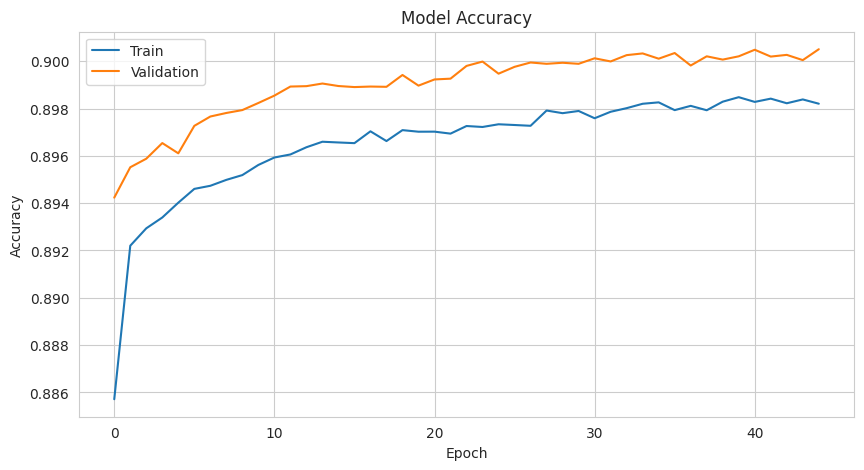

In [39]:
# Визуализация обучения модели по Accuracy
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Модель, согласно графику, показывает хорошую сходимость без признаков переобучения, хотя интересно отметить, что точность (accuracy) на валидационной выборке стабильно выше, чем на тренировочной.

In [40]:
# Выведем метрики, полученные на обученной нейронной сети
nn_best_metrics = model_quality_estimation(model)
display(nn_best_metrics)

5625/5625 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


{'Accuracy': 0.9002, 'Precision': 0.8965, 'Recall': 0.8765, 'F1-Score': 0.8864}

В заключение построим обобщающую таблицу, содержащую метрики по всем построенным в ходе работы моделям (LogisticRegression, RandomForestClassifier, Sequential).

In [41]:
# Данные метрик по всем посроенным моделям
metrics = [
    ["LogisticRegression", list(lr_best_metrics.values())],
    ["RandomForestClassifier", list(rf_best_metrics.values())],
    ["NeuralNetwork", list(nn_best_metrics.values())]
]

# Названия столбцов результирующей таблицы
columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]

# Преобразование массивов с данными по метрикам в отдельные элементы
data_for_df = []
for row in metrics:
    data_row = [row[0]] + row[1]
    data_for_df.append(data_row)

df_metrics = pd.DataFrame(data_for_df, columns=columns)

# Вывод обобщающей таблицы
print(df_metrics.to_string(index=False))

                 Model  Accuracy  Precision  Recall  F1-Score
    LogisticRegression    0.8851     0.8783  0.8603    0.8693
RandomForestClassifier    0.8993     0.8914  0.8805    0.8859
         NeuralNetwork    0.9002     0.8965  0.8765    0.8864


Исходя из полученных результатов видно, что лучше всего себя показала нейронная сеть (NeuralNetwork), продемонстрировавшая самый высокий показатель точности (accuracy) несмотря на то, что гиперпараметры сети специально не настраивались.

При этом стоит отметить, что разница по метрикам между нейронной сетью и случайным лесом (RandomForestClassifier) не является значительной, однако из-за скорости обучения приоритет был отдан нейронной сети/

In [42]:
# Сохранение финальной модели
model.save('cardiovascular_diseases.keras', include_optimizer=False)

# Предсказание классов на тестовой выборке

In [45]:
# Загружаем готовую модель
cardio_model = load_model("cardiovascular_diseases.keras")

In [50]:
# Предсказываем вероятности на тестовой выборке
test_proba = cardio_model.predict(cardio_test_copy.drop(['class'], axis=1))

# Создаём список всех предсказанных классов
test_pred = pd.Series((test_proba >= 0.5).astype(int).flatten(), name='class')

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


In [52]:
# Сохраняем получившийся список предсказаний в CSV
test_pred.to_csv("test_pred.csv", index=False)